# Using a CNN on Mel Spectograms to identify COVID-19 from coughs

Model reads in image files that have been created from cough audio files.
Machine learning is applied to create a classifier. Oversampling is used to balance the classes by adding duplicates of the minority class samples.

This Model uses ImageDataGenerator

Mounting the Google Drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Upload images to pandas dataframe and visualize a few images.

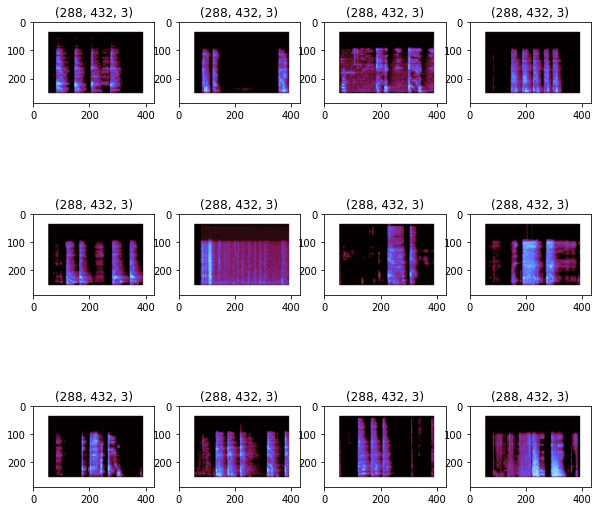

In [23]:
# Always run this code.
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from contextlib import redirect_stdout
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from sklearn.metrics import roc_curve

folder = '/content/drive/My Drive/Colab Notebooks/COVID-19'
if not os.path.exists(folder):
  print(folder + ' does not exist')


df_images = pd.read_csv(os.path.join(folder, 'df_train.csv'), index_col=0)

fnames = df_images.loc[:,'image_file']

plt.figure(figsize=(10,10))
for i in range(12): 
    plt.subplot(3,4,i+1)
    
    filename = fnames[i]
    if not os.path.exists(filename):
      print ('No such file:'+filename)
    
    image = imread(filename)
    plt.title(image.shape)
    plt.imshow(image)
    
plt.show()


In [24]:
pd.set_option('max_columns', None)
print(df_images.shape)
print(df_images.head(5))

(11401, 8)
                                     id   age  gender    status  \
0          Zb2Inq1UVhcMnWA41GpKyRdF4z62  66.0  female   healthy   
1  c4138919-bd2c-4e24-9fcf-582e428c7d27  37.0  female   healthy   
2          ygiPwZYsKFetOejhxWXB6rKSHAf2  66.0    male  COVID-19   
3  ec8ddd1e-d555-490f-9719-70a99c1c6993  29.0    male   healthy   
4          CFkIEzwZ5PcogCElOD2K3RJQzmh1  44.0    male   healthy   

                                          audio_file  \
0  /content/drive/My Drive/Colab Notebooks/coswar...   
1  /content/drive/My Drive/Colab Notebooks/coughv...   
2  /content/drive/My Drive/Colab Notebooks/coswar...   
3  /content/drive/My Drive/Colab Notebooks/coughv...   
4  /content/drive/My Drive/Colab Notebooks/coswar...   

                                          image_file    source  cough_detected  
0  /content/drive/My Drive/Colab Notebooks/coswar...   coswara             NaN  
1  /content/drive/My Drive/Colab Notebooks/coughv...  coughvid          1.0000  
2  /co

## Rearrange the dataset
Split into training set and validation set


In [25]:
# Always run this code.
validation_proportion = 0.3 #Change this if you want to change ratio of validation to training.

num_rows = df_images.shape[0]

df_val = df_images.iloc[:int(validation_proportion*num_rows)]
df_train = df_images.iloc[int(validation_proportion*num_rows):]

print (df_images.shape)
print (df_train.shape)
print (df_val.shape)

print (df_train.head(10))
print (df_val.head(10))

#Check we have a range of images in each set.

print(df_train.groupby('status').status.count())
print(df_val.groupby('status').status.count())

(11401, 8)
(7981, 8)
(3420, 8)
                                        id   age  gender    status  \
3420  6ea0f6b7-8110-4940-b848-0635be9b5978  29.0    male   healthy   
3421          zM5GsorprLYElGQ3uJwnU0g0Fwr1  35.0    male  COVID-19   
3422          bx564wHvi9d0HyJTtdi0haZuU493  28.0    male  COVID-19   
3423  07e2f7e1-8e9b-4962-8701-fbe1224de7ef  28.0    male   healthy   
3424  aeeb58ec-cefc-4d57-b2f5-db03cf502ae4   NaN  female   healthy   
3425  79319102-5fd0-46bd-b091-017b1c0973d1  52.0    male   healthy   
3426  f2d5ad83-91b7-4efe-9bc9-4adf3a08cf7d  30.0    male   healthy   
3427          KFtd9lY6jph5cl2VrZ9Nv8Jng7p1  42.0    male   healthy   
3428  1278ade5-08ec-4993-b5f8-8b8cf522e7be  45.0    male   healthy   
3429          E3nlERKGBPcSO2PjEDJ6GrRKiy73  47.0    male  COVID-19   

                                             audio_file  \
3420  /content/drive/My Drive/Colab Notebooks/coughv...   
3421  /content/drive/My Drive/Colab Notebooks/coswar...   
3422  /content/drive/

# Dealing with Imbalanced Dataset

Adding a copy of all COVID-19 images in training dataset to improve the balance of the data - **oversampling**.

In [26]:
#Create dataframe of just covid images from df_train
df_covid = df_train.loc[df_train.status =='COVID-19']
print(df_covid.shape)
print(df_covid.head())

(832, 8)
                                        id   age  gender    status  \
3421          zM5GsorprLYElGQ3uJwnU0g0Fwr1  35.0    male  COVID-19   
3422          bx564wHvi9d0HyJTtdi0haZuU493  28.0    male  COVID-19   
3429          E3nlERKGBPcSO2PjEDJ6GrRKiy73  47.0    male  COVID-19   
3431  522a43ec-3d80-43e4-97c9-c21ceb8b7a63  28.0  female  COVID-19   
3437          Z8ulmLPAsmhYfYuqUAmm6aGy5r53  32.0    male  COVID-19   

                                             audio_file  \
3421  /content/drive/My Drive/Colab Notebooks/coswar...   
3422  /content/drive/My Drive/Colab Notebooks/coswar...   
3429  /content/drive/My Drive/Colab Notebooks/coswar...   
3431  /content/drive/My Drive/Colab Notebooks/coughv...   
3437  /content/drive/My Drive/Colab Notebooks/coswar...   

                                             image_file    source  \
3421  /content/drive/My Drive/Colab Notebooks/coswar...   coswara   
3422  /content/drive/My Drive/Colab Notebooks/coswar...   coswara   
3429  /c

In [27]:
# Add copies of all COVID-19 images to dataframe df_train
covid = df_train.groupby('status').status.count()[0]
healthy = df_train.groupby('status').status.count()[1]
extra_required = healthy - covid

for i in range (int(extra_required/covid)):
  df_train = pd.concat([df_train,df_covid]) 

new_covid = int(extra_required/covid) * covid + covid

if healthy > new_covid:
  df_train = pd.concat([df_train,df_covid[:(healthy - new_covid)]])

df_train = df_train.sample(frac = 1) #shuffle dataframe
print(df_train.shape)
print(df_train.head())

print(df_train.groupby('status').status.count())

(14298, 8)
                                        id   age  gender    status  \
7190  72a71561-b8bd-4fb9-9edf-1cdfdbba767a  22.0    male   healthy   
4924                                 Hrnk2   NaN     NaN   healthy   
9076  b77e1bcc-b5f7-44f6-bfb6-bbd928844cb9  17.0    male   healthy   
4394                                  VDT2   NaN     NaN  COVID-19   
6977  05db06a5-4d1d-465e-9648-04efded46de4  41.0  female   healthy   

                                             audio_file  \
7190  /content/drive/My Drive/Colab Notebooks/coughv...   
4924  /content/drive/My Drive/Colab Notebooks/virufy...   
9076  /content/drive/My Drive/Colab Notebooks/coughv...   
4394  /content/drive/My Drive/Colab Notebooks/virufy...   
6977  /content/drive/My Drive/Colab Notebooks/coughv...   

                                             image_file    source  \
7190  /content/drive/My Drive/Colab Notebooks/coughv...  coughvid   
4924  /content/drive/My Drive/Colab Notebooks/virufy...    virufy   
9076  

Create input pipeline using ImageDataGenerator. 

In [28]:
# Always run this code.

batch_size = 100
img_height = 288
img_width = 432

# Rescaling of data moved to first layer of model
datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_data = datagen.flow_from_dataframe(df_train, x_col = "image_file", y_col = "status", 
                                               target_size = (img_height,img_width),  
                                               class_mode = "binary", batch_size = batch_size, 
                                               shuffle = True, validate_filenames = True)

val_data = datagen.flow_from_dataframe(df_val, x_col = "image_file", y_col = "status", 
                                           target_size = (img_height,img_width), 
                                           class_mode = "binary", batch_size = batch_size, 
                                           shuffle = False, validate_filenames = True)

Found 14298 validated image filenames belonging to 2 classes.
Found 3420 validated image filenames belonging to 2 classes.


# Creating Dataset

In [29]:
# Always run this code.
# Creating Datasets using ImageDatagenerator

train_dataset = tf.data.Dataset.from_generator(
    lambda: train_data,  
    output_types = (tf.float32 , tf.float32) , # output dtype
    output_shapes = ([None , 288 , 432 , 3] , [None , ]) # The 'None' enables different batch sizes when training.
)

valid_dataset = tf.data.Dataset.from_generator(
    lambda: val_data, 
    output_types = (tf.float32 , tf.float32), 
    output_shapes = ([None , 288 , 432 , 3] , [None , ])
)

train_dataset , valid_dataset

(<FlatMapDataset element_spec=(TensorSpec(shape=(None, 288, 432, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>,
 <FlatMapDataset element_spec=(TensorSpec(shape=(None, 288, 432, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>)

Need to add cardinality as otherwise the model will not know how many images there are.

In [30]:
# Always run this code.
train_dataset = train_dataset.apply(tf.data.experimental.assert_cardinality(df_train.shape[0])) #Check these numbers with validated files found in data generator section.
valid_dataset = valid_dataset.apply(tf.data.experimental.assert_cardinality(df_val.shape[0]))

len(train_dataset) , len(valid_dataset)

(14298, 3420)

Prefetching to make model faster.

In [31]:
# Enable prefetch (load it faster)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset = valid_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# CNN Network



Although there are built in measures for precision and recall, there are not the equivalent measures of specificity and negative prediction rate so I have had to create custom metrics for those.

I have used example in (tf.keras.metrics.Metric | TensorFlow Core v2.7.0) for Precision
 and changed it to calculate the metrics I need.

In [32]:
# Always run this code.
from keras.utils import metrics_utils
from keras.utils.generic_utils import to_list
from keras import backend
class Specificity(tf.keras.metrics.Metric):
  def __init__(self,
               thresholds=None,
               top_k=None,
               class_id=None,
               name=None,
               dtype=None):
    super(Specificity, self).__init__(name=name, dtype=dtype)
    self.init_thresholds = thresholds
    self.top_k = top_k
    self.class_id = class_id

    default_threshold = 0.5 if top_k is None else metrics_utils.NEG_INF
    self.thresholds = metrics_utils.parse_init_thresholds(
        thresholds, default_threshold=default_threshold)
    self._thresholds_distributed_evenly = (
        metrics_utils.is_evenly_distributed_thresholds(self.thresholds))
    self.true_negatives = self.add_weight(
        'true_negatives',
        shape=(len(self.thresholds),),
        initializer=tf.compat.v1.zeros_initializer)
    self.false_positives = self.add_weight(
        'false_positives',
        shape=(len(self.thresholds),),
        initializer=tf.compat.v1.zeros_initializer)

  def update_state(self, y_true, y_pred, sample_weight=None):
    """Accumulates true positive and false positive statistics.
    Args:
      y_true: The ground truth values, with the same dimensions as `y_pred`.
        Will be cast to `bool`.
      y_pred: The predicted values. Each element must be in the range `[0, 1]`.
      sample_weight: Optional weighting of each example. Defaults to 1. Can be a
        `Tensor` whose rank is either 0, or the same rank as `y_true`, and must
        be broadcastable to `y_true`.
    Returns:
      Update op.
    """
    return metrics_utils.update_confusion_matrix_variables(
        {
            metrics_utils.ConfusionMatrix.TRUE_NEGATIVES: self.true_negatives,
            metrics_utils.ConfusionMatrix.FALSE_POSITIVES: self.false_positives
        },
        y_true,
        y_pred,
        thresholds=self.thresholds,
        thresholds_distributed_evenly=self._thresholds_distributed_evenly,
        top_k=self.top_k,
        class_id=self.class_id,
        sample_weight=sample_weight)

  def result(self):
    result = tf.math.divide_no_nan(
        self.true_negatives,
        tf.math.add(self.true_negatives, self.false_positives))
    return result[0] if len(self.thresholds) == 1 else result

  def reset_state(self):
    num_thresholds = len(to_list(self.thresholds))
    backend.batch_set_value([(v, np.zeros((num_thresholds,)))
                             for v in (self.true_negatives,
                                       self.false_positives)])

  def get_config(self):
    config = {
        'thresholds': self.init_thresholds,
        'top_k': self.top_k,
        'class_id': self.class_id
    }
    base_config = super(Specificity, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

In [33]:
# Always run this code.
from keras.utils import metrics_utils
from keras.utils.generic_utils import to_list
from keras import backend
class NPV(tf.keras.metrics.Metric):
  def __init__(self,
               thresholds=None,
               top_k=None,
               class_id=None,
               name=None,
               dtype=None):
    super(NPV, self).__init__(name=name, dtype=dtype)
    self.init_thresholds = thresholds
    self.top_k = top_k
    self.class_id = class_id

    default_threshold = 0.5 if top_k is None else metrics_utils.NEG_INF
    self.thresholds = metrics_utils.parse_init_thresholds(
        thresholds, default_threshold=default_threshold)
    self._thresholds_distributed_evenly = (
        metrics_utils.is_evenly_distributed_thresholds(self.thresholds))
    self.true_negatives = self.add_weight(
        'true_negatives',
        shape=(len(self.thresholds),),
        initializer=tf.compat.v1.zeros_initializer)
    self.false_negatives = self.add_weight(
        'false_negatives',
        shape=(len(self.thresholds),),
        initializer=tf.compat.v1.zeros_initializer)

  def update_state(self, y_true, y_pred, sample_weight=None):
    """Accumulates true positive and false positive statistics.
    Args:
      y_true: The ground truth values, with the same dimensions as `y_pred`.
        Will be cast to `bool`.
      y_pred: The predicted values. Each element must be in the range `[0, 1]`.
      sample_weight: Optional weighting of each example. Defaults to 1. Can be a
        `Tensor` whose rank is either 0, or the same rank as `y_true`, and must
        be broadcastable to `y_true`.
    Returns:
      Update op.
    """
    return metrics_utils.update_confusion_matrix_variables(
        {
            metrics_utils.ConfusionMatrix.TRUE_NEGATIVES: self.true_negatives,
            metrics_utils.ConfusionMatrix.FALSE_NEGATIVES: self.false_negatives
        },
        y_true,
        y_pred,
        thresholds=self.thresholds,
        thresholds_distributed_evenly=self._thresholds_distributed_evenly,
        top_k=self.top_k,
        class_id=self.class_id,
        sample_weight=sample_weight)

  def result(self):
    result = tf.math.divide_no_nan(
        self.true_negatives,
        tf.math.add(self.true_negatives, self.false_negatives))
    return result[0] if len(self.thresholds) == 1 else result

  def reset_state(self):
    num_thresholds = len(to_list(self.thresholds))
    backend.batch_set_value([(v, np.zeros((num_thresholds,)))
                             for v in (self.true_negatives,
                                       self.false_negatives)])

  def get_config(self):
    config = {
        'thresholds': self.init_thresholds,
        'top_k': self.top_k,
        'class_id': self.class_id
    }
    base_config = super(NPV, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

# **Metrics available for use**

In [34]:
# Always run this cell.
precision = tf.keras.metrics.Precision(name = "precision")
recall = tf.keras.metrics.Recall(name = "recall")
specificity = Specificity(name = "specificity")
TP = tf.keras.metrics.TruePositives(name = "TP") 
FP = tf.keras.metrics.FalsePositives(name = "FP")
FN = tf.keras.metrics.FalseNegatives(name = "FN")
TN = tf.keras.metrics.TrueNegatives(name = "TN")
auc = tf.keras.metrics.AUC(name = "auc")
npv = NPV(name = "NPV")

# **Fit model on the training dataset**

In [35]:
#Run metrics available cell first to reset metrics
#Run this cell to create model or use next cell to load existing model.
model_name = "Covid_Model_mel_13.h5" #Change name here for each new model

model = keras.Sequential([              

    #Rescale the pixel values (integers between 0 and 255) to [0,1]. 
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), 
    layers.RandomTranslation(height_factor = 0, width_factor = 0.2, fill_mode='nearest'),
    
    # Block One
    layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same',
                  input_shape =[288,432,3]),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size = (2,2)),

    # Block Two
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='valid'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size = (2,2)),

    # Block Three
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='valid'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size = (2,2)),

    # Block Four
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='valid'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size = (2,2)),

    # Block Five
    layers.Conv2D(filters=512, kernel_size=3, activation='relu', padding='valid'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size = (2,2)),

    # Block Six
    layers.Conv2D(filters=1024, kernel_size=3, activation='relu', padding='valid'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size = (2,2)),

    # Head
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.25),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(1, activation='sigmoid'),
])

model._name= model_name[:-3]

model_plots_folder = os.path.join(folder,'model_plots')

# Save model summaries to a text file.
with open(os.path.join(model_plots_folder,'Model_summaries.txt'), 'a') as f:
    with redirect_stdout(f):
        model.summary()

# Save model plots to individual png files.
plot_model(
    model,
    to_file=(os.path.join(model_plots_folder, model_name[:-3] + ".png")),
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

model.summary()
plot_model(model, show_shapes=True)

es_callback = EarlyStopping(monitor = 'val_auc',
                            mode='max',
                            min_delta = 0.01,
                            patience = 10,
                            restore_best_weights = True)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[TP, FP, FN, TN, 
             npv, specificity, 
             recall, auc
             ]
)

history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    callbacks = [es_callback],
    epochs = 30,
    steps_per_epoch=len(train_dataset) // batch_size,
    validation_steps=len(valid_dataset) // batch_size)

Model: "Covid_Model_mel_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 288, 432, 3)       0         
                                                                 
 random_translation_2 (Rando  (None, 288, 432, 3)      0         
 mTranslation)                                                   
                                                                 
 conv2d_12 (Conv2D)          (None, 288, 432, 32)      896       
                                                                 
 batch_normalization_12 (Bat  (None, 288, 432, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 144, 216, 32)     0         
 g2D)                                                            
                                                

In [36]:
#Run again with a lower learning rate
precision = tf.keras.metrics.Precision(name = "precision")
recall = tf.keras.metrics.Recall(name = "recall")
specificity = Specificity(name = "specificity")
TP = tf.keras.metrics.TruePositives(name = "TP") 
FP = tf.keras.metrics.FalsePositives(name = "FP")
FN = tf.keras.metrics.FalseNegatives(name = "FN")
TN = tf.keras.metrics.TrueNegatives(name = "TN")
auc = tf.keras.metrics.AUC(name = "auc")
npv = NPV(name = "NPV")

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=[TP, FP, FN, TN, 
             npv, specificity, 
             recall, auc
             ]
)

history1 = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    callbacks = [es_callback],
    epochs = 60,
    initial_epoch=history.epoch[-1],
    steps_per_epoch=len(train_dataset) // batch_size,
    validation_steps=len(valid_dataset) // batch_size)

Epoch 15/60
142/142 [==============================] - 79s 537ms/step - loss: 0.5643 - TP: 5136.0000 - FP: 2345.0000 - FN: 1997.0000 - TN: 4720.0000 - NPV: 0.7027 - specificity: 0.6681 - recall: 0.7200 - auc: 0.7707 - val_loss: 0.7830 - val_TP: 1380.0000 - val_FP: 71.0000 - val_FN: 1702.0000 - val_TN: 247.0000 - val_NPV: 0.1267 - val_specificity: 0.7767 - val_recall: 0.4478 - val_auc: 0.6844
Epoch 16/60
142/142 [==============================] - 74s 523ms/step - loss: 0.5386 - TP: 5120.0000 - FP: 2101.0000 - FN: 1982.0000 - TN: 4995.0000 - NPV: 0.7159 - specificity: 0.7039 - recall: 0.7209 - auc: 0.7956 - val_loss: 0.6550 - val_TP: 1859.0000 - val_FP: 117.0000 - val_FN: 1223.0000 - val_TN: 201.0000 - val_NPV: 0.1412 - val_specificity: 0.6321 - val_recall: 0.6032 - val_auc: 0.6693
Epoch 17/60
142/142 [==============================] - 74s 525ms/step - loss: 0.5027 - TP: 5257.0000 - FP: 1837.0000 - FN: 1849.0000 - TN: 5255.0000 - NPV: 0.7397 - specificity: 0.7410 - recall: 0.7398 - auc: 

In [42]:
#Run again with a lower learning rate
precision = tf.keras.metrics.Precision(name = "precision")
recall = tf.keras.metrics.Recall(name = "recall")
specificity = Specificity(name = "specificity")
TP = tf.keras.metrics.TruePositives(name = "TP") 
FP = tf.keras.metrics.FalsePositives(name = "FP")
FN = tf.keras.metrics.FalseNegatives(name = "FN")
TN = tf.keras.metrics.TrueNegatives(name = "TN")
auc = tf.keras.metrics.AUC(name = "auc")
npv = NPV(name = "NPV")

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss='binary_crossentropy',
    metrics=[TP, FP, FN, TN, 
             npv, specificity, 
             recall, auc
             ]
)

history2 = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    callbacks = [es_callback],
    epochs = 60,
    initial_epoch=history1.epoch[-1],
    steps_per_epoch=len(train_dataset) // batch_size,
    validation_steps=len(valid_dataset) // batch_size)

Epoch 25/60
142/142 [==============================] - 85s 579ms/step - loss: 0.5416 - TP: 5129.0000 - FP: 2109.0000 - FN: 1971.0000 - TN: 4989.0000 - NPV: 0.7168 - specificity: 0.7029 - recall: 0.7224 - auc: 0.7935 - val_loss: 0.6248 - val_TP: 2020.0000 - val_FP: 127.0000 - val_FN: 1062.0000 - val_TN: 191.0000 - val_NPV: 0.1524 - val_specificity: 0.6006 - val_recall: 0.6554 - val_auc: 0.6811
Epoch 26/60
142/142 [==============================] - 75s 528ms/step - loss: 0.5307 - TP: 5170.0000 - FP: 2146.0000 - FN: 1901.0000 - TN: 4981.0000 - NPV: 0.7238 - specificity: 0.6989 - recall: 0.7312 - auc: 0.8032 - val_loss: 0.5926 - val_TP: 2153.0000 - val_FP: 141.0000 - val_FN: 929.0000 - val_TN: 177.0000 - val_NPV: 0.1600 - val_specificity: 0.5566 - val_recall: 0.6986 - val_auc: 0.6819
Epoch 27/60
142/142 [==============================] - 75s 532ms/step - loss: 0.5292 - TP: 5184.0000 - FP: 2074.0000 - FN: 1896.0000 - TN: 5044.0000 - NPV: 0.7268 - specificity: 0.7086 - recall: 0.7322 - auc: 

In [45]:
#Run again with a lower learning rate
precision = tf.keras.metrics.Precision(name = "precision")
recall = tf.keras.metrics.Recall(name = "recall")
specificity = Specificity(name = "specificity")
TP = tf.keras.metrics.TruePositives(name = "TP") 
FP = tf.keras.metrics.FalsePositives(name = "FP")
FN = tf.keras.metrics.FalseNegatives(name = "FN")
TN = tf.keras.metrics.TrueNegatives(name = "TN")
auc = tf.keras.metrics.AUC(name = "auc")
npv = NPV(name = "NPV")

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001),
    loss='binary_crossentropy',
    metrics=[TP, FP, FN, TN, 
             npv, specificity, 
             recall, auc
             ]
)

history3 = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    callbacks = [es_callback],
    epochs = 60,
    initial_epoch=history2.epoch[-1],
    steps_per_epoch=len(train_dataset) // batch_size,
    validation_steps=len(valid_dataset) // batch_size)

Epoch 35/60
142/142 [==============================] - 80s 543ms/step - loss: 0.5380 - TP: 5073.0000 - FP: 2149.0000 - FN: 1972.0000 - TN: 5004.0000 - NPV: 0.7173 - specificity: 0.6996 - recall: 0.7201 - auc: 0.7955 - val_loss: 0.6023 - val_TP: 2118.0000 - val_FP: 135.0000 - val_FN: 964.0000 - val_TN: 183.0000 - val_NPV: 0.1595 - val_specificity: 0.5755 - val_recall: 0.6872 - val_auc: 0.6797
Epoch 36/60
142/142 [==============================] - 74s 527ms/step - loss: 0.5339 - TP: 5171.0000 - FP: 2087.0000 - FN: 1904.0000 - TN: 5036.0000 - NPV: 0.7256 - specificity: 0.7070 - recall: 0.7309 - auc: 0.8008 - val_loss: 0.5912 - val_TP: 2165.0000 - val_FP: 141.0000 - val_FN: 917.0000 - val_TN: 177.0000 - val_NPV: 0.1618 - val_specificity: 0.5566 - val_recall: 0.7025 - val_auc: 0.6793
Epoch 37/60
142/142 [==============================] - 73s 518ms/step - loss: 0.5373 - TP: 5180.0000 - FP: 2108.0000 - FN: 1968.0000 - TN: 4942.0000 - NPV: 0.7152 - specificity: 0.7010 - recall: 0.7247 - auc: 0

In [46]:
model_folder = '/content/drive/My Drive/Colab Notebooks/models/'
model.save(model_folder + model_name)

In [ ]:
#Only run this cell if you want to reload model run previously.
model_folder = '/content/drive/My Drive/Colab Notebooks/models/'

custom_objects = {"NPV": NPV, "Specificity": Specificity}
with keras.utils.custom_object_scope(custom_objects):
    model = tf.keras.models.load_model(model_folder + "Covid_Model_mel_1.h5")

**Plot Training**

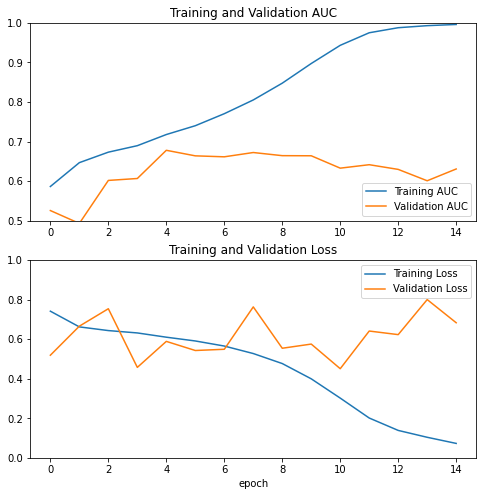

In [38]:
auc = history.history['auc']
val_auc = history.history['val_auc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(auc, label='Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation AUC')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

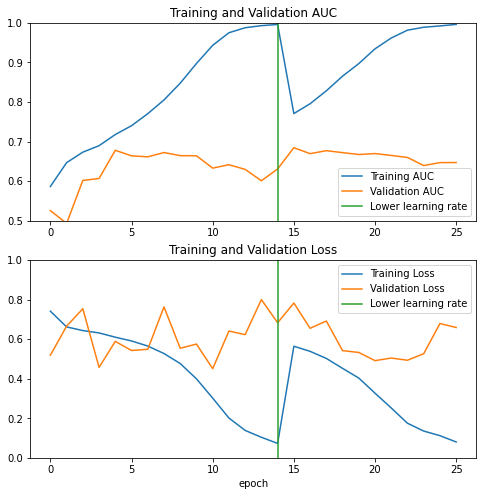

In [39]:
auc += history1.history['auc']
val_auc += history1.history['val_auc']

loss += history1.history['loss']
val_loss += history1.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(auc, label='Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.ylim([0.5, 1])
plt.plot([history.epoch[-1],history.epoch[-1]],
          plt.ylim(), label='Lower learning rate')
plt.legend(loc='lower right')
plt.title('Training and Validation AUC')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([history.epoch[-1],history.epoch[-1]],
         plt.ylim(), label='Lower learning rate')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# **Apply model to test dataset.**

In [40]:
# Import Test dataframe
df_test = pd.read_csv(os.path.join(folder, 'df_test.csv'), index_col=0)

#Rescale images in the same way as for train and validation sets
test_data = datagen.flow_from_dataframe(df_test, x_col = "image_file", y_col = "status", 
                                           target_size = (288,432), 
                                           class_mode = "binary", batch_size = batch_size, 
                                           shuffle = False, validate_filenames = True)

#Create dataset
test_dataset = tf.data.Dataset.from_generator(
    lambda: test_data, 
    output_types = (tf.float32 , tf.float32), 
    output_shapes = ([None , 288 , 432 , 3] , [None , ])
)

#Assert cardinality so the length can be used.
test_dataset = test_dataset.apply(tf.data.experimental.assert_cardinality(df_test.shape[0]))

Found 1000 validated image filenames belonging to 2 classes.


In [47]:
#Test model on test dataset
_,TP,FP,FN,TN, Spec, npv, Recall, AUC = model.evaluate(test_dataset, steps = df_test.shape[0]//batch_size)
print('Confusion Matrix: ', TP, FP, FN, TN)
print('Test NPV: %.4f' % npv)
print('Test Specificity: %.4f' % Spec)
print('Test Sensitivity: %.4f' % Recall)
print('Test ROC-AUC: %.4f' % AUC)

10/10 [==============================] - 5s 523ms/step - loss: 0.6115 - TP: 612.0000 - FP: 42.0000 - FN: 274.0000 - TN: 72.0000 - NPV: 0.2081 - specificity: 0.6316 - recall: 0.6907 - auc: 0.7082
Confusion Matrix:  612.0 42.0 274.0 72.0
Test NPV: 0.6316
Test Specificity: 0.2081
Test Sensitivity: 0.6907
Test ROC-AUC: 0.7082
